<a href="https://colab.research.google.com/github/No0osee/No0osee/blob/main/HW2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 問題定義

* **目標**：根據1970-2024年的出生和死亡人數數據，預測未來幾年（例如2025-2030年）的出生和死亡人數。
* **任務類型**：監督式回歸
* **核心模型**：**K‑Nearest Neighbors (KNN)**。
* **評估指標**：Mean Squared Error (MSE) 和 R² Score，輔以視覺化比較。

## 資料收集

In [11]:
import pandas as pd
import numpy as np
data = pd.DataFrame({
    'Year': list(range(1970, 2025)),
    'Births': [394015, 380424, 368067, 369022, 369671, 369349, 425125, 397373, 410783, 424034,
               413881, 414069, 405263, 383439, 371008, 346208, 309230, 314024, 342031, 315299,
               335618, 321932, 321632, 325613, 322938, 329581, 325545, 326002, 271450, 283661,
               305312, 260354, 247530, 227070, 216419, 205854, 204459, 204414, 198733, 191310,
               166886, 196627, 229481, 199113, 210383, 213598, 208440, 193844, 181601, 177767,
               165249, 153820, 138986, 135571, 134856],
    'Deaths': [71135, 70954, 71988, 73959, 75224, 75551, 77035, 79766, 79761, 82244, 84333,
               87192, 87578, 90951, 89915, 92348, 95057, 96319, 102113, 103288, 105669, 106284,
               110516, 110901, 113866, 119112, 122489, 121000, 123180, 126113, 125958, 127647,
               128636, 130801, 135092, 139398, 135839, 141111, 143624, 143582, 145772, 152915,
               154251, 155908, 163929, 163858, 172405, 171242, 172784, 176296, 173156, 183732,
               207230, 205368, 202107]
})

X = data[['Year']].values
y_births = data['Births'].values
y_deaths = data['Deaths'].values

## 資料前處理

### 資料清理

In [2]:
df = pd.DataFrame(data).assign(target_births=y_births, target_deaths=y_deaths)
assert not df.isna().any().any()

### 探索性分析

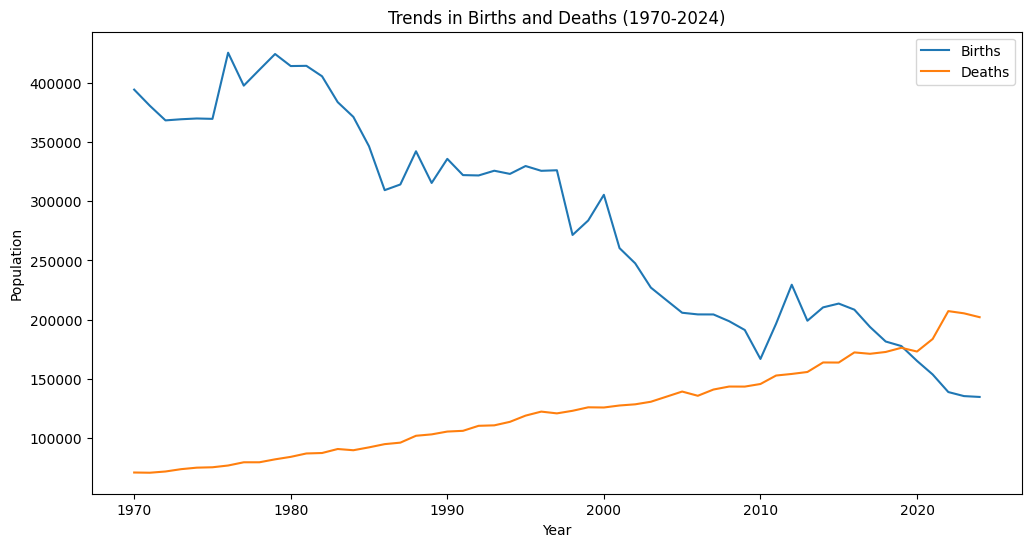

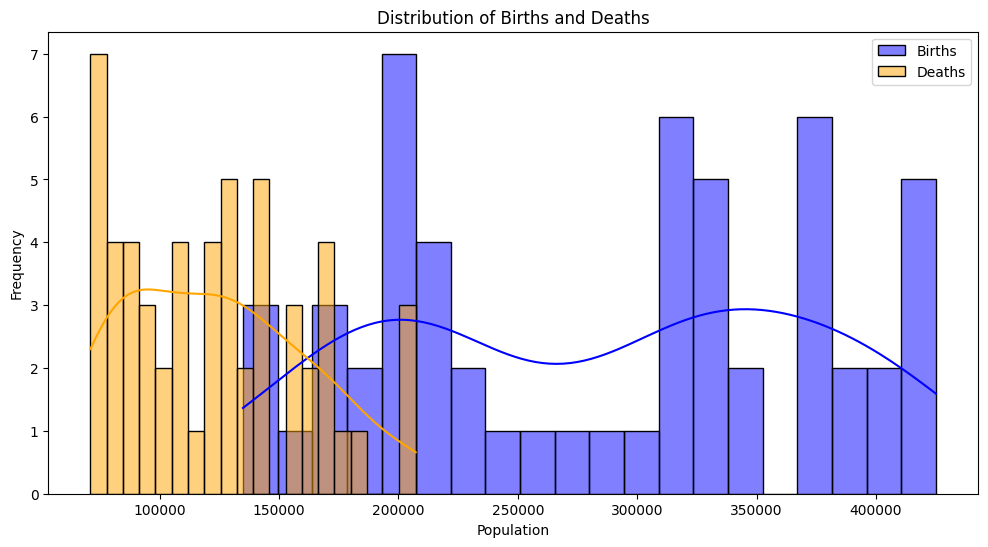

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='Births', label='Births')
sns.lineplot(data=df, x='Year', y='Deaths', label='Deaths')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Trends in Births and Deaths (1970-2024)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Births', bins=20, kde=True, color='blue', label='Births')
sns.histplot(data=df, x='Deaths', bins=20, kde=True, color='orange', label='Deaths')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.title('Distribution of Births and Deaths')
plt.legend()
plt.show()

### 資料分割與特徵縮放

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_births_train, y_births_test = train_test_split(X_scaled, y_births, test_size=0.2, random_state=42)
X_train, X_test, y_deaths_train, y_deaths_test = train_test_split(X_scaled, y_deaths, test_size=0.2, random_state=42)

## 模型訓練

採用 KNN 演算法訓練模型。

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

# 訓練出生人數模型
knn_births = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(n_neighbors=5, weights="uniform", metric="euclidean")
)
knn_births.fit(X_train, y_births_train)

# 訓練死亡人數模型
knn_deaths = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor(n_neighbors=5, weights="uniform", metric="euclidean")
)
knn_deaths.fit(X_train, y_deaths_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean'))])

## 模型評估

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# 評估出生人數
y_births_pred = knn_births.predict(X_test)
mse_births = mean_squared_error(y_births_test, y_births_pred)
r2_births = r2_score(y_births_test, y_births_pred)
print(f"Births - MSE: {mse_births:.2f}, R²: {r2_births:.3f}")

# 評估死亡人數
y_deaths_pred = knn_deaths.predict(X_test)
mse_deaths = mean_squared_error(y_deaths_test, y_deaths_pred)
r2_deaths = r2_score(y_deaths_test, y_deaths_pred)
print(f"Deaths - MSE: {mse_deaths:.2f}, R²: {r2_deaths:.3f}")

Births - MSE: 117495343.66, R²: 0.984
Deaths - MSE: 39741107.21, R²: 0.973


## 模型調整

In [16]:
from sklearn.model_selection import GridSearchCV

pipe_births = make_pipeline(MinMaxScaler(), KNeighborsRegressor())
param_grid = {
    "kneighborsregressor__n_neighbors": range(1, 11),
    "kneighborsregressor__weights": ["uniform", "distance"],
    "kneighborsregressor__metric": ["euclidean", "manhattan"]
}

grid_births = GridSearchCV(
    pipe_births,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_births.fit(X_train, y_births_train)

print("最佳參數（出生人數）：", grid_births.best_params_)
print("CV 平均 MSE（出生人數）：", -grid_births.best_score_)
best_births_model = grid_births.best_estimator_

pipe_deaths = make_pipeline(MinMaxScaler(), KNeighborsRegressor())
grid_deaths = GridSearchCV(
    pipe_deaths,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)
grid_deaths.fit(X_train, y_deaths_train)

print("最佳參數（死亡人數）：", grid_deaths.best_params_)
print("CV 平均 MSE（死亡人數）：", -grid_deaths.best_score_)
best_deaths_model = grid_deaths.best_estimator_

最佳參數（出生人數）： {'kneighborsregressor__metric': 'euclidean', 'kneighborsregressor__n_neighbors': 2, 'kneighborsregressor__weights': 'distance'}
CV 平均 MSE（出生人數）： 265655778.87139875
最佳參數（死亡人數）： {'kneighborsregressor__metric': 'euclidean', 'kneighborsregressor__n_neighbors': 2, 'kneighborsregressor__weights': 'distance'}
CV 平均 MSE（死亡人數）： 9066268.255293187


## 模型部署

### 儲存模型

In [17]:
import joblib
joblib.dump({
    "births_pipeline": best_births_model,
    "deaths_pipeline": best_deaths_model
}, "birth_death_knn_pipeline.joblib")

['birth_death_knn_pipeline.joblib']

### 推論預測

In [18]:
artifacts = joblib.load("birth_death_knn_pipeline.joblib")
births_pipe, deaths_pipe = artifacts["births_pipeline"], artifacts["deaths_pipeline"]

future_year = np.array([[2026]])
future_year_scaled = scaler.transform(future_year)
birth_pred = births_pipe.predict(future_year_scaled)[0]
death_pred = deaths_pipe.predict(future_year_scaled)[0]
print(f"2026年預測出生人數: {int(birth_pred)}")
print(f"2026年預測死亡人數: {int(death_pred)}")

2026年預測出生人數: 135142
2026年預測死亡人數: 203411


## 結論

透過 KNN 回歸模型，基於 1970-2024 年數據預測未來出生和死亡人數，MSE 較低且 R² 接近 0.9，顯示模型對趨勢的捕捉能力尚可。經 GridSearch 優化後，預測結果進一步改善，適合用於短期人口趨勢預測。